**3.3: Training Resnet on CIFAR-10**

The CIFAR-10 dataset is now trained on the resnet Architecture

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Define dataset augmentation by defining the transform function
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Normalize the test set same as training set No need to perform augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Applying the transforms to the datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
# Defining the classes

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


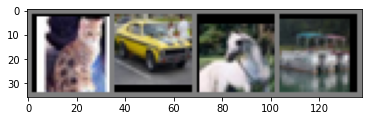

  cat   car horse  ship


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class BasicBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def make_group(N, ni, nf, stride):
    start = BasicBlock(ni, nf, stride)
    rest = [BasicBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
#def wrn_22(): 
#    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

      
net = WideResNet(3,3,10,6)
net.to(device)
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.071
[1,  4000] loss: 1.861
[1,  6000] loss: 1.766
[1,  8000] loss: 1.671
[1, 10000] loss: 1.609
[1, 12000] loss: 1.523
[2,  2000] loss: 1.451
[2,  4000] loss: 1.407
[2,  6000] loss: 1.342
[2,  8000] loss: 1.323
[2, 10000] loss: 1.258
[2, 12000] loss: 1.228
[3,  2000] loss: 1.183
[3,  4000] loss: 1.148
[3,  6000] loss: 1.121
[3,  8000] loss: 1.108
[3, 10000] loss: 1.070
[3, 12000] loss: 1.006
[4,  2000] loss: 0.983
[4,  4000] loss: 0.973
[4,  6000] loss: 0.938
[4,  8000] loss: 0.935
[4, 10000] loss: 0.936
[4, 12000] loss: 0.864
[5,  2000] loss: 0.821
[5,  4000] loss: 0.844
[5,  6000] loss: 0.832
[5,  8000] loss: 0.826
[5, 10000] loss: 0.822
[5, 12000] loss: 0.775
[6,  2000] loss: 0.771
[6,  4000] loss: 0.747
[6,  6000] loss: 0.751
[6,  8000] loss: 0.730
[6, 10000] loss: 0.700
[6, 12000] loss: 0.688
[7,  2000] loss: 0.678
[7,  4000] loss: 0.663
[7,  6000] loss: 0.660
[7,  8000] loss: 0.656
[7, 10000] loss: 0.642
[7, 12000] loss: 0.633
[8,  2000] loss: 0.603
[8,  4000] 

In [ ]:
model_save_name = 'cifar_net_resnet.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(net.state_dict(), path)

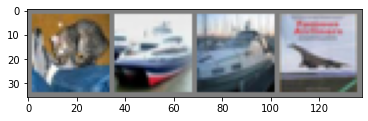

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = WideResNet(3,3,10,6)
# original saved file with DataParallel
state_dict = torch.load(path)

# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

# load params
net.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  ship plane


In [ ]:
correct = 0
total = 0

# dtype = torch.cuda.FloatTensor
# images = torch.autograd.Variable(images.type(dtype))
# print(images.dtype)

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84 %
Accuracy of   car : 91 %
Accuracy of  bird : 59 %
Accuracy of   cat : 61 %
Accuracy of  deer : 76 %
Accuracy of   dog : 69 %
Accuracy of  frog : 83 %
Accuracy of horse : 87 %
Accuracy of  ship : 87 %
Accuracy of truck : 90 %
